  0%|          | 0/16 [00:00<?, ?it/s]

   parameters          aic
0      (3, 2)  5512.508882
1      (1, 3)  5548.704622
2      (2, 3)  5548.746376
3      (3, 3)  5550.580175
4      (2, 1)  5551.067679
5      (3, 1)  5552.702417
6      (2, 2)  5552.771938
7      (1, 2)  5577.976144
8      (3, 0)  5601.026909
9      (1, 1)  5602.211183
10     (2, 0)  5611.863493
11     (1, 0)  5643.031712
12     (0, 3)  7002.506973
13     (0, 2)  7528.392577
14     (0, 1)  8469.027430
15     (0, 0)  9983.724768
                              ARMA Model Results                              
Dep. Variable:               meantemp   No. Observations:                 1462
Model:                     ARMA(3, 2)   Log Likelihood               -2749.254
Method:                       css-mle   S.D. of innovations              1.585
Date:                Sun, 08 May 2022   AIC                           5512.509
Time:                        15:03:37   BIC                           5549.522
Sample:                    01-01-2013   HQIC                       

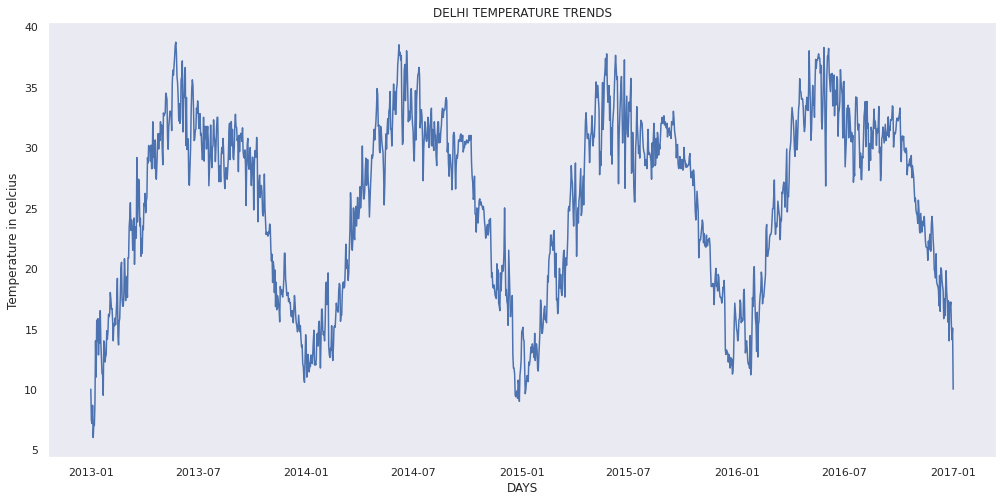

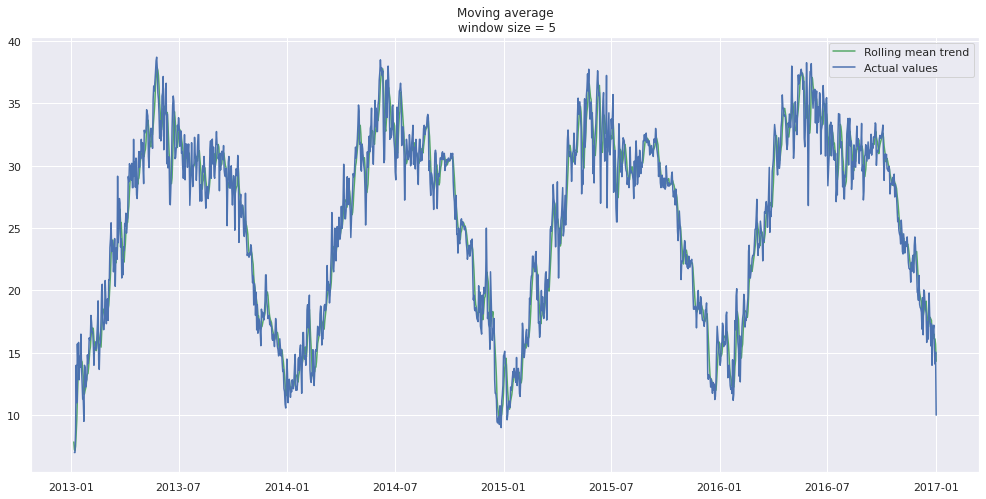

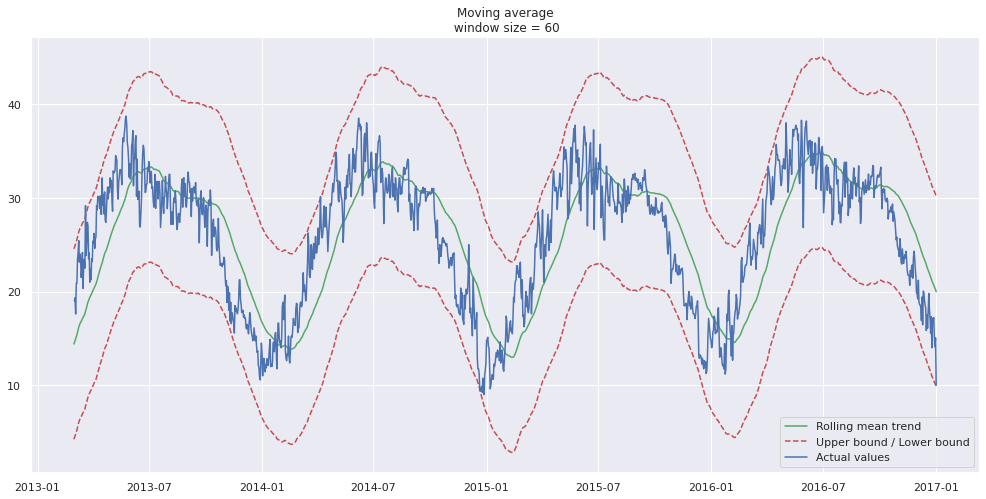

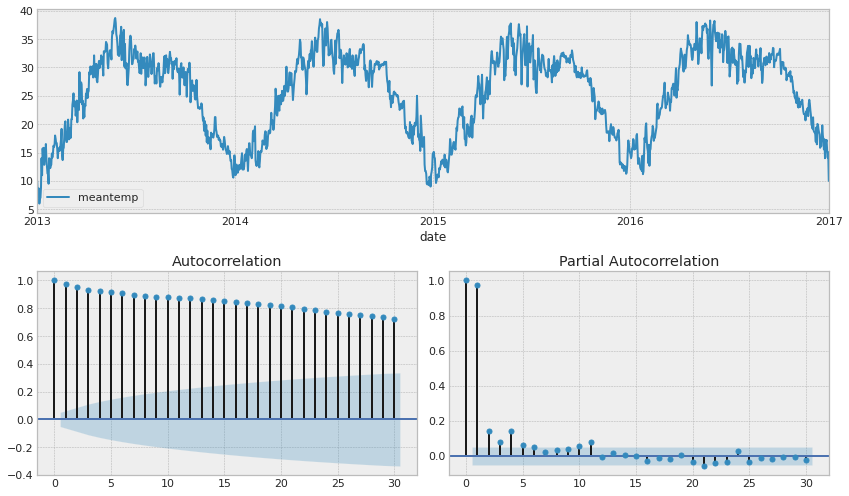

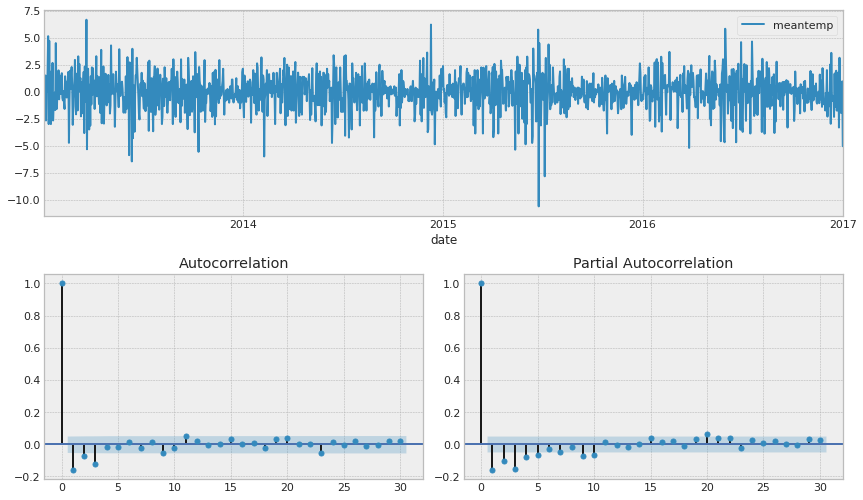

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
!pip install statsmodels==0.12.1


from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from tqdm import tqdm_notebook

from itertools import product
def mean_absolute_percentage_error(y_true,y_pred):
  return np.mean(np.abs((y_true-y_pred)/y_true))*100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
data=pd.read_csv('/content/DailyDelhiClimateTrain.csv',index_col=['date'], parse_dates=['date'])
dropcol=['humidity','wind_speed','meanpressure']
data.drop(dropcol,axis=1,inplace=True)
plt.figure(figsize=(17,8))
plt.plot(data)
plt.title('DELHI TEMPERATURE TRENDS')
plt.xlabel('DAYS')
plt.ylabel('Temperature in celcius')
plt.grid(False)
def plot_moving_average(series,window,plot_intervals=False,scale=1.5):
  rolling_mean=series.rolling(window=window).mean()
  plt.figure(figsize=(17,8))
  plt.title('Moving average\n window size = {}'.format(window))
  plt.plot(rolling_mean, 'g', label='Rolling mean trend')
  if plot_intervals:
    mae=mean_absolute_error(series[window:],rolling_mean[window:])
    deviation=np.std(series[window:]-rolling_mean[window:])
    lower_bound = rolling_mean - (mae + scale * deviation)
    upper_bound = rolling_mean + (mae + scale * deviation)
    plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
    plt.plot(lower_bound, 'r--')

  plt.plot(series[window:], label='Actual values')
  plt.legend(loc='best')
  plt.grid(True)
plot_moving_average(data, 5)
plot_moving_average(data,60,plot_intervals=True)

def tsplot(y,lags=None,figsize=(12,7),style='bmh'):
  

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))

        y.plot(ax=ts_ax)
       
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
tsplot(data,30)
data_diff = data - data.shift(1)


tsplot(data_diff[1:], lags=30)

ps = range(0, 4)
d = 0
qs = range(0, 4)


#Create a list with all possible combinations of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)
def optimize_ARIMA(parameters_list,d):
  results = []
  best_aic = float('inf')
    
  for param in tqdm_notebook(parameters_list):
    model = sm.tsa.ARIMA(data,order=(param[0],d,param[1])).fit(disp=-1)

    aic = model.aic
    
        
        #Save best model, AIC and parameters
    if aic < best_aic:
      best_model = model
      
      best_aic = aic
      
      best_param = param
      
     
    results.append([param, model.aic])
  table=pd.DataFrame(results)
  #print(table)
  table.columns=['parameters','aic']
  table =table.sort_values('aic', ascending=True).reset_index(drop=True)
  return table
  

table=optimize_ARIMA(parameters_list,d)
print(table)

p, q = table.parameters[0]

best_model = sm.tsa.ARIMA(data, order = (p,d,q)).fit(disp = -1)

print(best_model.summary())

In [ ]:
test = pd.read_csv('/content/DailyDelhiClimateTest.csv', index_col=['date'], parse_dates=['date'])
drcol=['humidity','wind_speed','meanpressure']
test.drop(drcol,axis=1,inplace=True)
model = ARIMA(test, order=(2,1,2))
model_fit = model.fit()

yhat = best_model.predict(2,50, typ='levels')
#print(yhat)
#mean_absolute_percentage_error(data[2:51], float(yhat))
mean_squared_error(data[2:51], yhat[0:])

3.3519556148512892